Save full images as jpgs with 3 channels:
 1. actual image
 2. mask
 3. zeros, just here so images can be saved as jpegs
 
Images are a minimum of 1280 pixels wide, a portion of the black background is trimmed to keep the images mostly usable. The height is unaltered. No zooming is done to the images at all.

These images will be read off of disk and randomly cropped in TensorFlow to provide more training data in files of reasonable sizes.

In [82]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import random
import glob
import shutil
import re
from scipy.misc import imresize, toimage
from mammo_utils import create_mask, half_image, get_fuzzy_offset, progress, clean_name, random_flip_image
%matplotlib inline

In [144]:
def create_cbis_slices(mask_dir,image_dir,  name, debug=True):
    # initialize return variables
    image_list = []
    pixel_means_list = []
    
    # get list of files in the directory
    image_files = os.listdir(image_dir)
    counter = 0
    
    # display the progress bar
    if debug is None:
        progress(counter, len(image_files), 'WORKING')
       
    # make sure the destination directory exists
    if not os.path.exists(os.path.join("data", name)):
        os.mkdir(os.path.join("data", name))
    
    # loop through the masks
    for cur_image in image_files:
        
        # update the progress bar
        counter += 1
        if debug is None:
            progress(counter, len(image_files), cur_image)
            
        # get the image name
        base_image_file = clean_name(cur_image)
        
        full_image = PIL.Image.open(os.path.join(image_dir, cur_image))
        full_image_arr = np.array(full_image)[:,:,0]
        
        # find which masks match, there may be more than one
        matching_masks = glob.glob(os.path.join(mask_dir, base_image_file + "*" + ".jpg"))
        
        # create a blank mask same size as image
        mask_image = np.zeros_like(full_image_arr)
        
        # loop through the masks
        for mask in matching_masks:
            # load the mask
            cur_mask = np.array(PIL.Image.open(os.path.join(mask_dir, mask)))[:,:,0]
            
            # if the mask is the right shape
            if mask_image.shape == cur_mask.shape:
                # update our global mask accordingly
                mask_image[cur_mask > 0] = 1
        
        # try to remove some of the black background from the image
        mostly_black_cols = np.sum(full_image_arr < 10, axis=0)
        image_mostly_black = mostly_black_cols > (full_image_arr.shape[0] * 0.90)
        
        # determine which way the image is oriented
        first_black_col = np.argmax(image_mostly_black)
        
        # if there are a substantial number of mostly black columns then we will try to trim them
        if np.sum(image_mostly_black) > (full_image_arr.shape[1] * 0.15):
            # if the first black col is not at the beginning we trim from the right
            if first_black_col > 500:
                # add some padding
                first_black_col += 300
                
                # make sure the image is at least 1280 pixels wide
                first_black_col = np.max([first_black_col, 1280])
                
                # include up to the first black col
                full_image_arr = full_image_arr[:,:first_black_col]
                mask_image = mask_image[:,:first_black_col]

            # else we need to reverse the array and trim from the left
            else:
                first_black_col = len(image_mostly_black) - np.argmax(np.flip(image_mostly_black, axis=0))

                # add some padding
                first_black_col -= 300
                
                # make sure the image is at least 1280 pixels wide
                first_black_col = np.min([first_black_col, full_image_arr.shape[1] - 1280])
                
                # trim from the right
                full_image_arr = full_image_arr[:,first_black_col:]
                mask_image = mask_image[:,first_black_col:]
            
        # set white pixels to 1 instead of 255
#         mask_image[mask_image > 0] = 1
        
        # alert if image is way too small
        if full_image_arr.shape[1] < 1000:
            print("Image too small!", cur_image)
            print(mask, full_image_arr.shape)
        
        # make sure the mask and image are the same size
        if full_image_arr.shape != mask_image.shape:
            print("Shapes don't match", cur_image)
            continue
        else:
            # add the mean of the mask to the mean list
            pixel_means_list.append(np.mean(mask_image))
            
            # save the image
            image = np.dstack((full_image_arr, mask_image, np.zeros_like(full_image_arr))).astype(np.uint8)
            
            im = PIL.Image.fromarray(image)
            im.save(os.path.join("data", name, base_image_file + "_" + str(counter) + ".png"))
            
#         if counter > 10:
#             break
        
    # return the data
    return pixel_means_list

In [145]:
def plot_random_samples(images, N=20):
    idxs = random.sample(range(len(images)), k=N)

    for idx in idxs:
        f, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(images[idx][:,:,0])
        ax[0].set_title("Image")
        ax[1].imshow(images[idx][:,:,1])
        ax[1].set_title("Label")
        plt.show()

## All Images At Once

In [158]:
# load the labels
test_labels = pd.read_pickle(os.path.join("data", "test_labels.pkl"))
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\All Masks"
image_dir = "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\All Images"

mu = create_cbis_slices(mask_dir, image_dir, name="mask_images", debug=None)

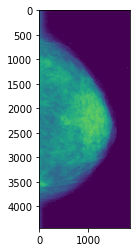

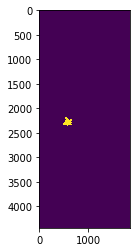

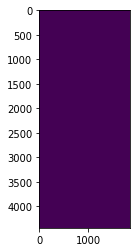

In [161]:
full_image_arr = PIL.Image.open("C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\mask_images\\P_00009_RIGHT_CC_14.png")
full_image_arr = np.array(full_image_arr)

plt.imshow(full_image_arr[:,:,0])
plt.show()

plt.imshow(full_image_arr[:,:,1])
plt.show()

plt.imshow(full_image_arr[:,:,2])
plt.show()

In [165]:
print("Pixel mean:",np.mean(mu))

Pixel mean: 0.01393677365042314


## Move Files to Proper Directories

In [176]:
test_images = os.listdir("C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\Test Images")

for image in test_images:
    base_image_name = clean_name(image)
    
    matching_images = glob.glob("C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\train_images\\" + base_image_name + "*.png")
    if len(matching_images):
        for test_image in matching_images:
            file_name = test_image.split("\\")[-1]
            print(file_name)
#             os.rename(test_image, "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\test_images\\" + file_name)